<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-END-Program/blob/main/11-%20HandsOn%205/Convolutional_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution based Seq2Seq machine translation

Convolution based German to English translation.

In [1]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 1.2MB 18.1MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [2]:
# Import necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Extension of Flickr30K dataset. Contains German trnaslations of English descriptions.
import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import time
import math

print(torchtext.__version__)

0.6.0


In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Download and load spacy models for DE and EN.

In [4]:
# Download and load spacy models for DE and EN languages. To be used for tokenization.
%%bash
python -m spacy download en
python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907057 sha256=d1c3ac857803210b3ef1fac8dd9b12856615b637d194b040987e99a3bbe1cefd
  Stored in directory: /tmp/pip-ephem-wheel-cache-i_ymheik/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [5]:
# After linking spacy.load('de_core_news_sm') -> spacy.load('de')
spacy_de = spacy.load('de')
# After linking spacy.load('en_core_web_sm') -> spacy.load('en')
spacy_en = spacy.load('en')

### Prepare tokenizers

Takes in string and returns list of tokens. Will be passed to torchtext.

In [6]:
# Tokenizer for German. 
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

### Prepare FIELDS

Defines a datatype together with instructions for converting to Tensor. holds a Vocab object that defines the set of possible values
    for elements of the field and their corresponding numerical representations.

Torchtext provides data in [seq_len, batch_size] dimension. Convolution based model requires batch_size in first dimension- [batch_size, seq_len]. This is done by batch_first=True in Field definition.

Data pre process

'zwei junge weiße männer sind im freien in der nähe vieler büsche'. --> tokenize --> 'zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'  --> Indexing --> [32,12,45,56,...]

SRC is German and TRG is English.

In [7]:
SRC = Field(tokenize = tokenize_de, init_token = '<SOS>', eos_token = '<EOS>', lower = True, batch_first = True)
TRG = Field(tokenize = tokenize_en, init_token = '<SOS>', eos_token = '<EOS>', lower = True, batch_first = True)

### Download Multi30K dataset and load train, test and val data.

In [8]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 637kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 174kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 162kB/s]


In [9]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [10]:
print(vars(train_data.examples[0]))

{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


### Build vocabulary for SRC and TRG

Vocabulary will associate each unique tokens with an index. Only tokens that appear atleast 2 times are considered. Other such words are replaced by < UNK >. Vocab object built on only training examples.

In [11]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [12]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7855
Unique tokens in target (en) vocabulary: 5893


In [13]:
# SRC.vocab dict has the following keys - freqs(provides word and its frequencies), itos(mapping of integer to string), 
# stoi(mapping of string to its integer) and vectors()
print(SRC.vocab.__dict__.keys())
SRC.vocab.__dict__

dict_keys(['freqs', 'itos', 'unk_index', 'stoi', 'vectors'])


{'freqs': Counter({'zwei': 3873,
          'junge': 2068,
          'weiße': 146,
          'männer': 1662,
          'sind': 490,
          'im': 3107,
          'freien': 475,
          'in': 11893,
          'der': 4989,
          'nähe': 383,
          'vieler': 2,
          'büsche': 5,
          '.': 28821,
          'mehrere': 580,
          'mit': 8843,
          'schutzhelmen': 33,
          'bedienen': 9,
          'ein': 18850,
          'antriebsradsystem': 1,
          'kleines': 772,
          'mädchen': 2121,
          'klettert': 171,
          'spielhaus': 2,
          'aus': 910,
          'holz': 61,
          'mann': 7805,
          'einem': 13711,
          'blauen': 992,
          'hemd': 1202,
          'steht': 1778,
          'auf': 8745,
          'einer': 6765,
          'leiter': 56,
          'und': 8925,
          'putzt': 43,
          'fenster': 148,
          'stehen': 939,
          'am': 911,
          'herd': 17,
          'bereiten': 79,
          '

### Create iterators for train, valid and test.

BucketIterator is used instead of Standard Iterator. BucketIterator defines an iterator that batches examples of similar lengths together.

Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch.

batch.src - [ (128) , (128), .. 23 times]**bold text**

In [14]:
BATCH_SIZE = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), batch_size = BATCH_SIZE, device = device)

device

device(type='cuda')

In [15]:
batch = next(iter(train_iterator))
print(batch,"\n")
print(f"Source sequence of shape [batch_size, src_len]-{batch.trg.shape} \n",batch.src[0])
print(f"Target of shape [batch_size, src_len]-{batch.trg.shape} \n",batch.trg[0])

# Index     String
#    0       <UNK>
#    1       <pad>
#    2       <SOS>
#    3       <EOS>
#    4         .


[torchtext.data.batch.Batch of size 128 from MULTI30K]
	[.src]:[torch.cuda.LongTensor of size 128x23 (GPU 0)]
	[.trg]:[torch.cuda.LongTensor of size 128x21 (GPU 0)] 

Source sequence of shape [batch_size, src_len]-torch.Size([128, 21]) 
 tensor([  2,   8,  16,   7,  14, 331, 256,  31,  12,  24, 268,   4,   3,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1], device='cuda:0')
Target of shape [batch_size, src_len]-torch.Size([128, 21]) 
 tensor([  2,  14,  13,  90,  23,  32,   6, 243,   5,   3,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1], device='cuda:0')


### Build model.

#### Encoder

![](https://github.com/bentrevett/pytorch-seq2seq/raw/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq1.png)

In [16]:
class Encoder(nn.Module):
    def __init__(self,input_dim, emb_dim, hid_dim, kernel_size, n_layers, dropout, device, max_length=100):
        super().__init__()
        assert kernel_size % 2 == 1, "Kernel size must be odd!"        
        self.device = device        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)

        self.token_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)

        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)

        # Module list to apply 'N' conv blocks
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2*hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size-1)//2)
                                    for _ in range(n_layers)
        ])

        self.dropout = nn.Dropout(dropout)

    
    def forward(self, src):
        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos = [batch_size, src_len]

        tok_embedding = self.token_embedding(src)
        pos_embedding = self.pos_embedding(pos)

        embedded = self.dropout(tok_embedding + pos_embedding)

        conv_input = self.emb2hid(embedded)
        # conv_input = [batch_size, src_len, hid_dim]

        # Convolution requires input in dimension [batch_size, hid_dim, src_len]. Therefore permute.
        conv_input = conv_input.permute(0,2,1)
        # conv_input = [batch_size, hid_dim, src_len]

        for i, conv in enumerate(self.convs):
            conved = conv(self.dropout(conv_input))
            # conved = [batch_size, 2*hid_dim, src_len]. glu reduces given dim by half. Therefore doubling number of channels during convolution.
            conved = F.glu(conved, dim=1)
            # conved = [batch_size, hid_dim, src_len]
            # applying residual on conv output
            conved = (conved + conv_input) * self.scale
            # With summing, amplitude as well as gradient is doubled. Hence the sum is scaled by scaling factor=0.5 to normalize.
            conv_input = conved 
            # conv_input = conved = [batch_size, hid_dim, src_len]
        
        # To reverse the dim change done for convolution operation, apply permute. Apply FC to convert back to emb_dim
        conved = self.hid2emb(conved.permute(0,2,1))
        # conved = [batch_size, src_len, emb_dim]
        # Residual connection
        combined = (conved + embedded) * self.scale
        # combined = [batch_size, src_len, emb_dim]
        
        return conved, combined


#### Decoder

Decoder module is similar to the encoder but for these differences-

1. Decoder does not have the residual connection connecting embedding vector with convolution output. Instead, embedding vector is fed to the conv block to be usedfor the residual connection within it.

2. Encoder output- conved and combined are fed to the decoder into the conv block.

3. Output of the decoder is fed to linear layer which converts into output dimension. This helps in making the prediction for the next word.

4. During convolution, unlike in encoder where padding was applied equally on both ends of the sentence, padding in decoder is applied only at the beginning of the sentence. This is to ensure the kernel only looks at the previous and current word for processing and prevent it from looking at the next word (token that needs to be predicted). This helps in preventing the model from copying the next word and not learning to translate. 

![](https://github.com/bentrevett/pytorch-seq2seq/raw/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq3.png)

In [29]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, kernel_size, n_layers, dropout, trg_pad_idx, device, max_length=100):
        super().__init__()

        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
       
        self.token_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)

        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)

        self.fc_out = nn.Linear(emb_dim, output_dim)

        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2*hid_dim, 
                                              kernel_size = kernel_size)
                                    for _ in range(n_layers)
        ])

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)

        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
    
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        # embedded = [batch_size, src_len, emb_dim]
        # conved = [batch_size, hid_dim, trg_len]
        # encoder_conved = encoder_combined = [batch_size, src_len, emb_dim]

        # conved dimension [batch_size, hid_dim, trg_len]. Required output to be of form [batch_size, trg_len, emb_dim]. Hence, permuting and appling FC.
        conved_emb = self.attn_hid2emb(conved.permute(0,2,1))
        # conved_emb = [batch_size, trg_len, emb_dim]

        combined = (conved_emb + embedded) * self.scale
        # combined = [batch_size, trg_len, emb_dim]

        # encoder_conved = [batch_size, src_len, emb_dim]
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        # energy = [batch_size, trg_len, src_len]

        attention = F.softmax(energy, dim=2)
        # attention = [batch_size, trg_len, src_len]

        # encoder_combined = [batch_size, src_len, emb_dim]
        attended_encoding = self.attn_emb2hid(torch.matmul(attention, encoder_combined))
        # matmul output = [batch_size, trg_len, emb_dim]
        # FC output = [batch_size, trg_len, hid_dim]

        # residual connection
        # conved = [batch_size, hid_dim, trg_len]
        # attended_encoding = [batch_size, trg_len, hid_dim]
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        # attended_combined = [batch_size, hid_dim, trg_len]

        return attention, attended_combined
    
    
    def forward(self, trg, encoder_conved, encoder_combined):
        # trg = [batch_size, trg_len]
        # encoder_conved = encoder_combined = [batch_size, src_len, emb_dim]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        # position tensor
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos = [batch_size, trg_len]

        # embedding vector
        token_embedded = self.token_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        #  token_embedded = [batch_size, trg_len, emb_dim]
        #  pos_embedded = [batch_size, trg_len, emb_dim]

        # elementwise sum to get combined embedding
        embedded = self.dropout(token_embedded + pos_embedded)
        # embedded = [batch_size, trg_len, emb_dim]

        # convert emb_dim to hid_dim
        conv_input = self.emb2hid(embedded)
        # conv_input = [batch_size, trg_len, hid_dim]

        # permute for convolution layer
        conv_input = conv_input.permute(0, 2, 1)
        # conv_input = [batch_size, hid_dim, trg_len]

        hid_dim = conv_input.shape[1]

        for i, conv in enumerate(self.convs):

            conv_input = self.dropout(conv_input)

            # padding at the beginning to prevent decoder cheating.
            padding = torch.zeros(batch_size, hid_dim, self.kernel_size-1).fill_(self.trg_pad_idx).to(self.device)  
            # padding = [batch_size, hid_dim, kernel_size-1] filled with trg_pad_idx

            # padding padded with conv_input along trg_len dimension
            padded_conv_input = torch.cat((padding, conv_input), dim=2)
            # padded_conv_input = [batch_size, hid_dim, (trg_len + kernel_size - 1)]

            # convolution
            conved = conv(padded_conv_input)
            # conved = [batch_size, 2*hid_dim, trg_len]

            #  GLU activation. Reduces hid_dim by half.
            conved = F.glu(conved, dim=1)
            # conved = [batch_size, hid_dim, trg_len]

            # attention calculation
            attention, conved = self.calculate_attention(embedded, conved, encoder_conved, encoder_combined)
            # attention = [btach_size, trg_len, src_len]

            # residual connection with input to conv and conv output
            conved = (conved + conv_input) * self.scale
            # conved = [batch_size, hid_dim, trg_len]

            # set conv_input = conved for next convolution block
            conv_input = conved

        # convert conved back into emb_dim
        conved = self.hid2emb(conved.permute(0, 2, 1))
        # conved = [batch_size, trg_len, emb_dim]

        output = self.fc_out(self.dropout(conved))
        # output = [batch_size, trg_len, output_dim]

        return output, attention


#### Seq2Seq model

In [30]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg):
        # src = [batch_size, src_len]
        # trg = [batch_size, trg_len-1] -- <EOS> is sliced off

        encoder_conved, encoder_combined = self.encoder(src)
        # encoder_conved (output from convolution block) = [batch_size, src_len, emb_dim]
        # encoder_combined (output from conv block + embedding vector) = [batch_size, src_len, emb_dim]

        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        # output (prediction for each word in target sentence) = [batch_size, trg_len - 1, output_dim]
        # attention (attention score for each word in target sentence)= [batch_size, trg_len - 1, src_len]

        return output, attention

### Training Seq2Seq model

In [31]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512
ENC_LAYERS = 10
DEC_LAYERS = 10
ENC_KERNEL_SIZE = 3
DEC_KERNEL_SIZE = 3
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
# Setting index of pad_token from target language vocabulary.
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_KERNEL_SIZE, ENC_LAYERS, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_KERNEL_SIZE, DEC_LAYERS, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,351,685 trainable parameters


Define optimizer and criterion

In [33]:
optimizer = optim.Adam(model.parameters())

In [34]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training loop

trg structure is [sos, x1, x2,... eos] => xi is the token in target sentence. 

eos from end of sentence is sliced off by using trg[:-1] to get [sos, x1, x2,...]

output structure is [y1, y2, .... eos]. For loss calculation, sos is stripped by using trg[1:] to get [x1, x2,....eos].




In [35]:
def train(model, iterator, optimizer, criterion, clip):    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        output, _ = model(src, trg[:,:-1])
        #output = [batch_size, trg_len - 1, output_dim]
        #trg = [batch_size, trg_len]
        
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #output = [batch_size * trg_len - 1, output_dim]
        #trg = [batch_size * trg_len - 1]

        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


In [36]:
def evaluate(model, iterator, criterion):        
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])        
            #output = [batch_size, trg_len - 1, output_dim]
            #trg = [batch_size, trg_len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch_size * trg_len - 1, output_dim]
            #trg = [batch_size * trg_len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [37]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [38]:
train_loss_all = []
valid_loss_all = []

In [39]:
N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 2s
	Train Loss: 4.170 | Train PPL:  64.722
	 Val. Loss: 2.907 |  Val. PPL:  18.293
Epoch: 02 | Time: 1m 2s
	Train Loss: 2.976 | Train PPL:  19.617
	 Val. Loss: 2.350 |  Val. PPL:  10.481
Epoch: 03 | Time: 1m 3s
	Train Loss: 2.581 | Train PPL:  13.213
	 Val. Loss: 2.130 |  Val. PPL:   8.412
Epoch: 04 | Time: 1m 3s
	Train Loss: 2.361 | Train PPL:  10.599
	 Val. Loss: 1.989 |  Val. PPL:   7.307
Epoch: 05 | Time: 1m 2s
	Train Loss: 2.203 | Train PPL:   9.048
	 Val. Loss: 1.919 |  Val. PPL:   6.813
Epoch: 06 | Time: 1m 2s
	Train Loss: 2.095 | Train PPL:   8.122
	 Val. Loss: 1.854 |  Val. PPL:   6.385
Epoch: 07 | Time: 1m 2s
	Train Loss: 2.004 | Train PPL:   7.418
	 Val. Loss: 1.812 |  Val. PPL:   6.122
Epoch: 08 | Time: 1m 3s
	Train Loss: 1.932 | Train PPL:   6.902
	 Val. Loss: 1.788 |  Val. PPL:   5.977
Epoch: 09 | Time: 1m 3s
	Train Loss: 1.869 | Train PPL:   6.484
	 Val. Loss: 1.753 |  Val. PPL:   5.771
Epoch: 10 | Time: 1m 2s
	Train Loss: 1.816 | Train PPL:   6.145


In [41]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.792 | Test PPL:   6.001 |


#### Train, val loss curve

In [42]:
import matplotlib.pyplot as plt
def train_test_metrics_graph(train_loss_all, val_loss_all):

    plt.plot(train_loss_all, label="Train Loss")
    plt.plot(val_loss_all, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch curve")

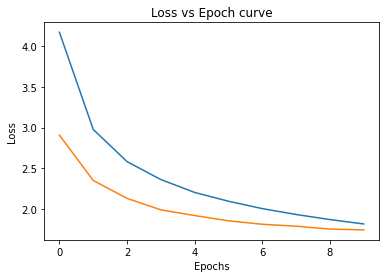

In [43]:
train_test_metrics_graph(train_loss_all, valid_loss_all)

### Inference

In [44]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)        
        pred_token = output.argmax(2)[:,-1].item()        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]    
    return trg_tokens[1:], attention

In [45]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [49]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'kleines', 'mädchen', 'klettert', 'in', 'ein', 'spielhaus', 'aus', 'holz', '.']
trg = ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.']


In [50]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'little', 'girl', 'climbs', 'into', 'a', 'playhouse', 'playhouse', 'of', 'wood', '.', '<EOS>']


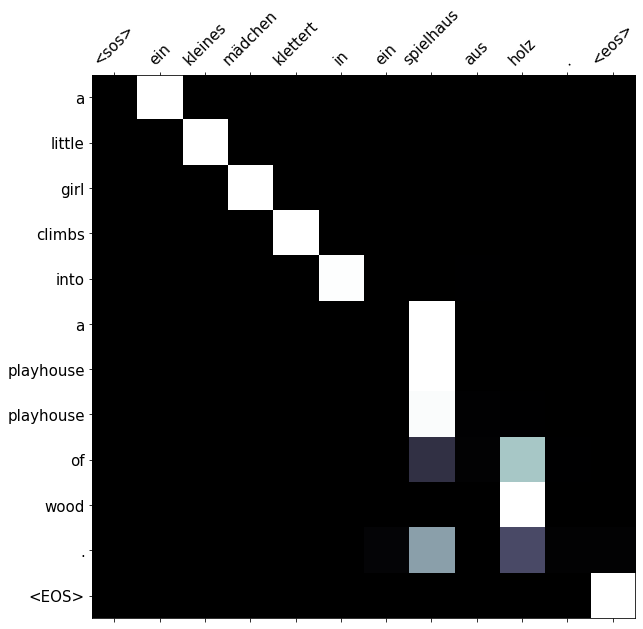

In [48]:
display_attention(src, translation, attention)

#### On validation set

In [51]:
example_idx = 2

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'junge', 'mit', 'kopfhörern', 'sitzt', 'auf', 'den', 'schultern', 'einer', 'frau', '.']
trg = ['a', 'boy', 'wearing', 'headphones', 'sits', 'on', 'a', 'woman', "'s", 'shoulders', '.']


In [52]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'boy', 'wearing', 'headphones', 'sits', 'on', 'the', 'shoulders', 'of', 'a', 'woman', '.', '<EOS>']


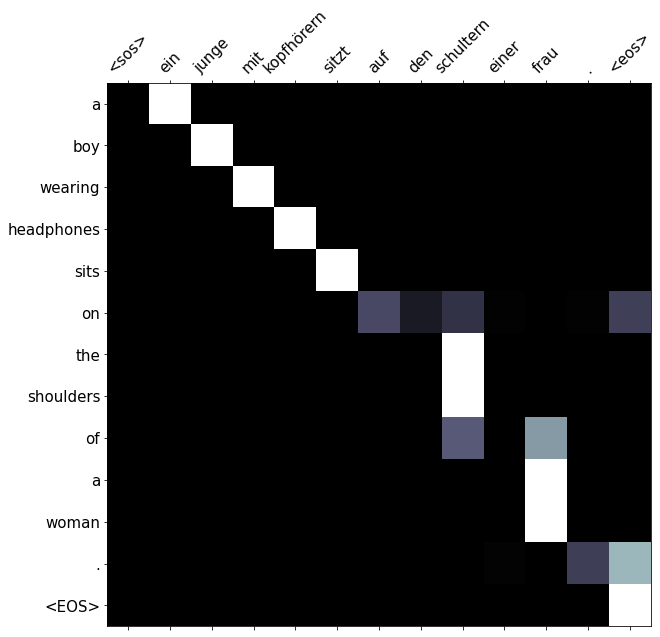

In [53]:
display_attention(src, translation, attention)

#### On test set

In [54]:

example_idx = 9

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'mann', 'in', 'einer', 'weste', 'sitzt', 'auf', 'einem', 'stuhl', 'und', 'hält', 'magazine', '.']
trg = ['a', 'man', 'in', 'a', 'vest', 'is', 'sitting', 'in', 'a', 'chair', 'and', 'holding', 'magazines', '.']


In [55]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'man', 'in', 'a', 'vest', 'is', 'sitting', 'on', 'a', 'chair', 'holding', '<unk>', '.', '<EOS>']


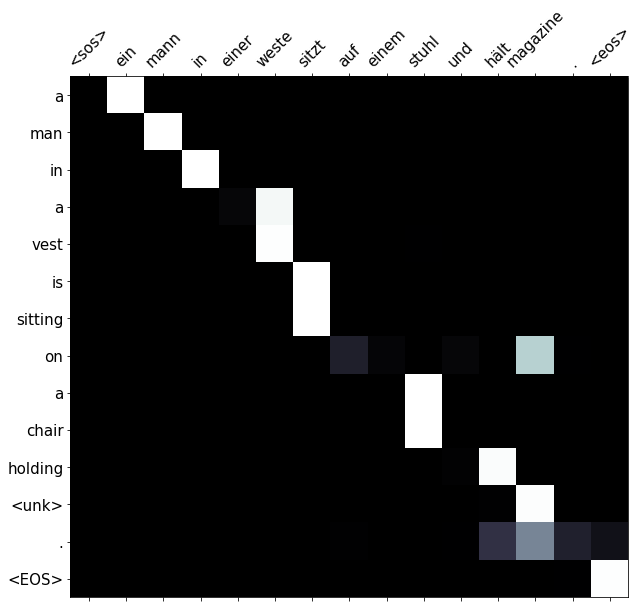

In [56]:
display_attention(src, translation, attention)

### BLEU score

In [57]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [58]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 34.89
